In [1]:
import torch
import torch.nn as nn
import numpy as np
from functools import partial

from torch.optim.lr_scheduler import StepLR

from model import NN
from model import save_model, load_model
from functions import gaussian_loss_function
from train import training_routine, testing_routine
from visuals import plot_transformed_grid_and_density, compute_gaussian_density, compute_uniform_circle_density
from visuals import plot_concat_density

from matplotlib import pyplot as plt

from pathlib import Path

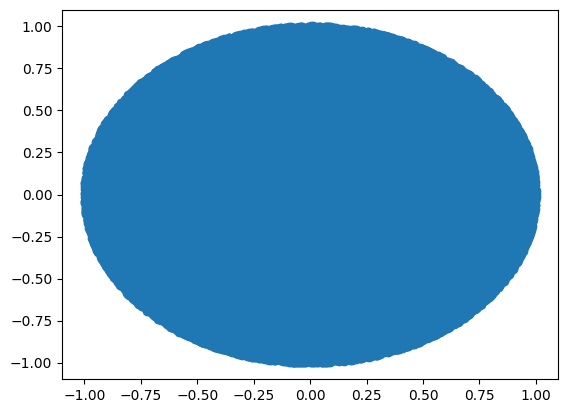

In [28]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data), axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

training_set = generate_ellipse(max_num=100000, scale=(1,1.), device=device)
validation_set = generate_ellipse(max_num=10000, scale=(1.,1), device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [3]:
model_circle = NN(num_coupling_layers=30, split_size_x1=1, nn_size=(1, 10)).to(device)


In [4]:
optimizer = torch.optim.SGD(model_circle.parameters(), lr=1., momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [317]:
%%time

for epoch in range(num_epoch):
    training_routine(model_circle, train_loader, optimizer, gaussian_loss_function) 
    print(testing_routine(model_circle, validation_loader, gaussian_loss_function))
    scheduler.step()

77it [00:09,  7.73it/s]
62it [00:02, 27.77it/s]


tensor(3770.6917, device='cuda:0')


77it [00:09,  7.96it/s]
62it [00:02, 29.48it/s]


tensor(3953.2910, device='cuda:0')


77it [00:09,  7.89it/s]
62it [00:02, 28.39it/s]


tensor(3817.0359, device='cuda:0')


77it [00:09,  7.94it/s]
62it [00:02, 29.20it/s]


tensor(3883.5055, device='cuda:0')


77it [00:09,  7.93it/s]
62it [00:02, 29.72it/s]


tensor(3811.1226, device='cuda:0')


77it [00:09,  7.87it/s]
62it [00:02, 29.54it/s]


tensor(3836.0098, device='cuda:0')


77it [00:09,  7.91it/s]
62it [00:02, 28.96it/s]


tensor(3766.5807, device='cuda:0')


77it [00:09,  7.85it/s]
62it [00:02, 28.57it/s]


tensor(3778.9588, device='cuda:0')


77it [00:09,  7.83it/s]
62it [00:02, 28.53it/s]


tensor(3908.4095, device='cuda:0')


77it [00:09,  7.89it/s]
62it [00:02, 29.14it/s]


tensor(3792.4177, device='cuda:0')


77it [00:10,  7.52it/s]
62it [00:02, 29.34it/s]


tensor(3780.3731, device='cuda:0')


77it [00:09,  7.86it/s]
62it [00:02, 29.07it/s]


tensor(3747.1490, device='cuda:0')


77it [00:09,  7.92it/s]
62it [00:02, 29.01it/s]


tensor(3733.7437, device='cuda:0')


77it [00:09,  7.84it/s]
62it [00:02, 28.85it/s]


tensor(3744.8487, device='cuda:0')


77it [00:09,  7.90it/s]
62it [00:02, 29.89it/s]


tensor(3794.6646, device='cuda:0')


77it [00:09,  7.97it/s]
62it [00:02, 29.74it/s]


tensor(3710.5111, device='cuda:0')


77it [00:09,  7.97it/s]
62it [00:02, 29.51it/s]


tensor(3919.1893, device='cuda:0')


77it [00:09,  7.90it/s]
62it [00:02, 29.06it/s]


tensor(3820.5142, device='cuda:0')


77it [00:10,  7.69it/s]
62it [00:02, 28.69it/s]


tensor(3699.6327, device='cuda:0')


77it [00:09,  7.83it/s]
62it [00:02, 28.55it/s]

tensor(3768.4587, device='cuda:0')
CPU times: total: 4min 43s
Wall time: 3min 58s


0

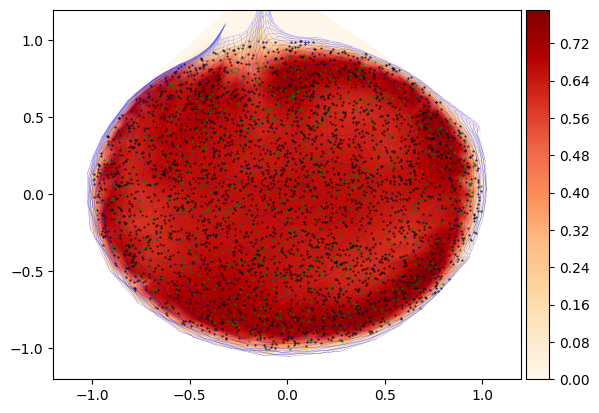

In [29]:
scale=1.2
factor=4

sampling_data = torch.tensor(np.random.normal(size=(1000,2)))
plot_transformed_grid_and_density(model_circle, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1*scale,1*scale), y_lim=(-1*scale,1*scale),
                                density_function=compute_gaussian_density, name='circle_gaussian.png')

In [17]:
save_model(model_circle, data = 'ellipse', checkpoint_number=1)
model_loaded = load_model(device, num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,10), path=f"./acl_gaussian/ellipse/experiment{1}.pth")

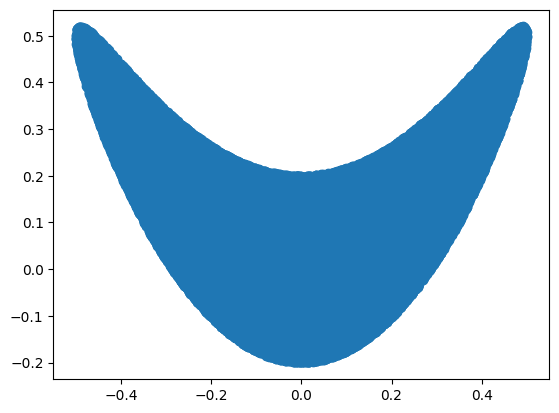

In [19]:
def generate_banana(n=100000, device=device):
    train_loader = generate_ellipse(n, device=device)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
training_set = generate_banana(n=100000, device=device)
validation_set = generate_banana(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [7]:
model_banana = NN(num_coupling_layers=30, split_size_x1=1, nn_size=(1, 10)).to(device)

In [8]:
optimizer = torch.optim.SGD(model_banana.parameters(), lr=1., momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [326]:
%%time

for epoch in range(num_epoch):
    training_routine(model_banana, train_loader, optimizer, gaussian_loss_function) 
    print(testing_routine(model_banana, validation_loader, gaussian_loss_function))
    scheduler.step()

77it [00:09,  7.91it/s]
62it [00:02, 29.40it/s]


tensor(-14094.8111, device='cuda:0')


77it [00:09,  7.88it/s]
62it [00:02, 28.35it/s]


tensor(-13985.8267, device='cuda:0')


77it [00:09,  7.96it/s]
62it [00:02, 28.24it/s]


tensor(-14114.1977, device='cuda:0')


77it [00:09,  7.96it/s]
62it [00:02, 28.66it/s]


tensor(-14124.8642, device='cuda:0')


77it [00:09,  7.92it/s]
62it [00:02, 29.03it/s]


tensor(-14187.9577, device='cuda:0')


77it [00:09,  7.95it/s]
62it [00:02, 28.76it/s]


tensor(-14224.7836, device='cuda:0')


77it [00:09,  7.88it/s]
62it [00:02, 28.96it/s]


tensor(-13993.1274, device='cuda:0')


77it [00:09,  7.88it/s]
62it [00:02, 28.63it/s]


tensor(-14078.0998, device='cuda:0')


77it [00:09,  7.85it/s]
62it [00:02, 29.41it/s]


tensor(-14159.6459, device='cuda:0')


77it [00:09,  7.99it/s]
62it [00:02, 28.06it/s]


tensor(-14137.7941, device='cuda:0')


77it [00:09,  8.04it/s]
62it [00:02, 29.05it/s]


tensor(-14076.5731, device='cuda:0')


77it [00:09,  8.03it/s]
62it [00:02, 29.04it/s]


tensor(-14241.5264, device='cuda:0')


77it [00:09,  7.97it/s]
62it [00:02, 28.26it/s]


tensor(-14163.5727, device='cuda:0')


77it [00:09,  7.84it/s]
62it [00:02, 28.88it/s]


tensor(-14255.9068, device='cuda:0')


77it [00:09,  7.94it/s]
62it [00:02, 29.07it/s]


tensor(-14258.2494, device='cuda:0')


77it [00:09,  8.04it/s]
62it [00:02, 29.14it/s]


tensor(-14248.2860, device='cuda:0')


77it [00:09,  8.01it/s]
62it [00:02, 29.31it/s]


tensor(-14245.6607, device='cuda:0')


77it [00:09,  8.00it/s]
62it [00:02, 28.93it/s]


tensor(-14228.6840, device='cuda:0')


77it [00:09,  7.92it/s]
62it [00:02, 29.82it/s]


tensor(-14282.1394, device='cuda:0')


77it [00:09,  7.97it/s]
62it [00:02, 27.09it/s]

tensor(-14239.1165, device='cuda:0')
CPU times: total: 4min 40s
Wall time: 3min 56s


0

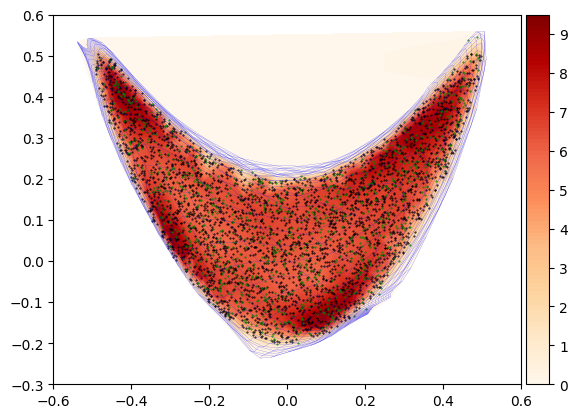

In [12]:
scale=1.2
factor=4

sampling_data = torch.tensor(np.random.normal(size=(1000,2)))
plot_transformed_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.5*scale),
                                density_function=compute_gaussian_density, name='banana_gaussian_2.png')

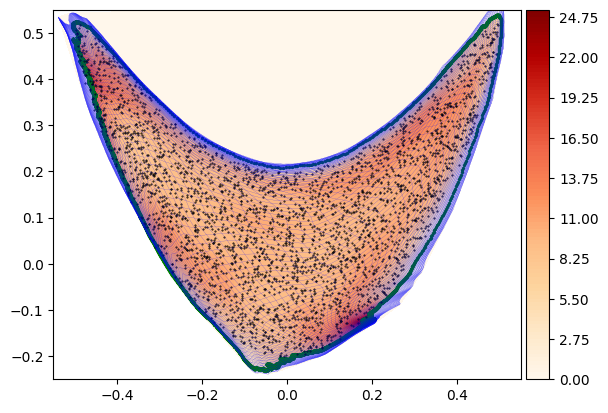

In [21]:
plot_concat_density(device, model_circle, model_banana, training_set.cpu().numpy(), sigma_range = 4, grid_width=100, boundary_points=20000, x_lim=(-0.55, 0.55), y_lim=(-0.25, 0.55), name='concat_banana.png')

In [14]:
save_model(model_banana, data = 'banana', checkpoint_number=1)
model_loaded = load_model(device, num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,10), path=f"./acl_gaussian/banana/experiment{1}.pth")

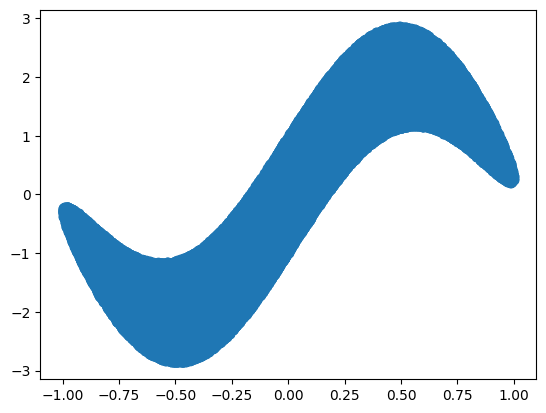

In [22]:
def generate_wave(n=100000, device='cpu'):
    train_loader = generate_ellipse(n, (1,1), device)
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
training_set = generate_wave(n=100000, device=device)
validation_set = generate_wave(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [331]:
model_wave = NN(num_coupling_layers=30, split_size_x1=1, nn_size=(1, 10)).to(device)

In [332]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=1., momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [344]:
%%time

for epoch in range(num_epoch):
    training_routine(model_wave, train_loader, optimizer, gaussian_loss_function) 
    print(testing_routine(model_wave, validation_loader, gaussian_loss_function))
    scheduler.step()

77it [00:09,  8.22it/s]
62it [00:02, 29.37it/s]


tensor(4078.6246, device='cuda:0')


77it [00:09,  8.11it/s]
62it [00:02, 29.30it/s]


tensor(4125.1722, device='cuda:0')


77it [00:09,  8.08it/s]
62it [00:02, 30.01it/s]


tensor(4210.5284, device='cuda:0')


77it [00:09,  7.99it/s]
62it [00:02, 30.62it/s]


tensor(4132.4315, device='cuda:0')


77it [00:09,  7.89it/s]
62it [00:02, 30.78it/s]


tensor(4031.4564, device='cuda:0')


77it [00:09,  8.05it/s]
62it [00:02, 30.02it/s]


tensor(4099.7885, device='cuda:0')


77it [00:09,  8.07it/s]
62it [00:02, 30.01it/s]


tensor(4070.2221, device='cuda:0')


77it [00:09,  8.10it/s]
62it [00:02, 30.42it/s]


tensor(4188.6045, device='cuda:0')


77it [00:09,  8.09it/s]
62it [00:02, 30.50it/s]


tensor(4017.1034, device='cuda:0')


77it [00:09,  8.02it/s]
62it [00:02, 30.21it/s]


tensor(3979.9934, device='cuda:0')


77it [00:09,  8.07it/s]
62it [00:02, 30.56it/s]


tensor(4042.2449, device='cuda:0')


77it [00:09,  7.96it/s]
62it [00:02, 29.74it/s]


tensor(4148.3594, device='cuda:0')


77it [00:09,  8.03it/s]
62it [00:02, 30.47it/s]


tensor(3975.3205, device='cuda:0')


77it [00:09,  8.06it/s]
62it [00:02, 30.94it/s]


tensor(4034.0811, device='cuda:0')


77it [00:09,  8.00it/s]
62it [00:02, 30.29it/s]


tensor(4104.9771, device='cuda:0')


77it [00:09,  8.01it/s]
62it [00:02, 30.69it/s]


tensor(4045.2889, device='cuda:0')


77it [00:09,  7.98it/s]
62it [00:02, 30.80it/s]


tensor(4028.7001, device='cuda:0')


77it [00:09,  7.82it/s]
62it [00:02, 30.72it/s]


tensor(3928.4238, device='cuda:0')


77it [00:09,  8.07it/s]
62it [00:02, 30.29it/s]


tensor(3950.5097, device='cuda:0')


77it [00:09,  8.00it/s]
62it [00:02, 30.10it/s]

tensor(3928.3707, device='cuda:0')
CPU times: total: 4min 41s
Wall time: 3min 52s


C:\Users\Admin\AppData\Local\Temp\ipykernel_15384\789167566.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

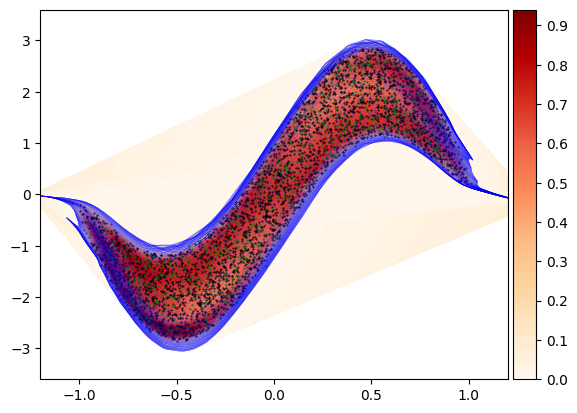

In [387]:
scale=1.2
factor=4

sampling_data = torch.tensor(np.random.normal(size=(1000,2)))
plot_transformed_grid_and_density(model_wave, training_set.to('cpu'), device, sampling_data, grid_width=100,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1*scale,1*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_gaussian_density, name='wave_gaussian_2.png')

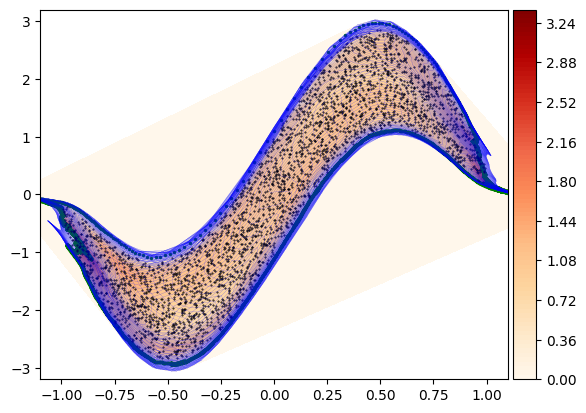

In [346]:
plot_concat_density(device, model_circle, model_wave, training_set.cpu().numpy(), sigma_range = 4, grid_width=100, boundary_points=20000, x_lim=(-1.1, 1.1), y_lim=(-3.2, 3.2), name='concat_wave.png')

In [23]:
save_model(model_wave, data = 'wave', checkpoint_number=1)
model_loaded = load_model(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,10), path=f"./acl_gaussian/wave/experiment{1}.pth")

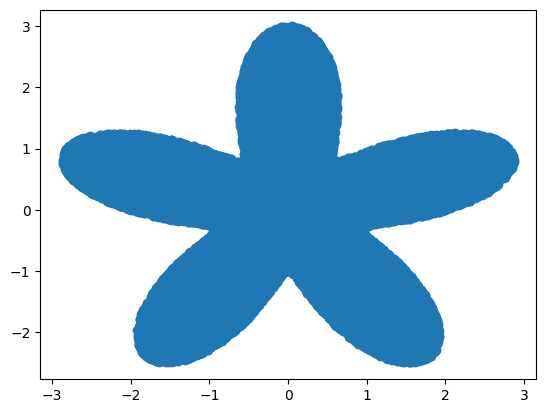

In [24]:
def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

training_set = generate_star(max_num=100000, n_edges=5, device=device)
validation_set = generate_star(max_num=10000, n_edges=5, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [25]:
model_star = NN(num_coupling_layers=50, split_size_x1=1, nn_size=(1, 10)).to(device)

In [376]:
optimizer = torch.optim.SGD(model_star.parameters(), lr=1., momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [380]:
%%time

for epoch in range(num_epoch):
    training_routine(model_star, train_loader, optimizer, gaussian_loss_function) 
    print(testing_routine(model_star, validation_loader, gaussian_loss_function))
    scheduler.step()

39it [00:07,  4.94it/s]
32it [00:01, 18.15it/s]


tensor(8244.8549, device='cuda:0')


39it [00:08,  4.81it/s]
32it [00:01, 17.56it/s]


tensor(8243.5710, device='cuda:0')


39it [00:08,  4.79it/s]
32it [00:01, 17.70it/s]


tensor(8196.8480, device='cuda:0')


39it [00:08,  4.81it/s]
32it [00:01, 18.02it/s]


tensor(8446.2805, device='cuda:0')


39it [00:08,  4.66it/s]
32it [00:01, 17.51it/s]


tensor(8242.6973, device='cuda:0')


39it [00:08,  4.80it/s]
32it [00:01, 17.84it/s]


tensor(8174.8295, device='cuda:0')


39it [00:08,  4.80it/s]
32it [00:01, 17.59it/s]


tensor(8227.4317, device='cuda:0')


39it [00:08,  4.79it/s]
32it [00:01, 17.78it/s]


tensor(8165.7915, device='cuda:0')


39it [00:08,  4.77it/s]
32it [00:01, 17.71it/s]


tensor(8186.1686, device='cuda:0')


39it [00:08,  4.79it/s]
32it [00:01, 18.00it/s]


tensor(8180.4167, device='cuda:0')


39it [00:08,  4.78it/s]
32it [00:01, 17.19it/s]


tensor(8222.9740, device='cuda:0')


39it [00:08,  4.78it/s]
32it [00:01, 17.55it/s]


tensor(8205.5999, device='cuda:0')


39it [00:08,  4.82it/s]
32it [00:01, 17.42it/s]


tensor(8140.8861, device='cuda:0')


39it [00:08,  4.78it/s]
32it [00:01, 17.36it/s]


tensor(8167.7563, device='cuda:0')


39it [00:08,  4.77it/s]
32it [00:01, 17.52it/s]


tensor(8119.5760, device='cuda:0')


39it [00:08,  4.75it/s]
32it [00:01, 17.97it/s]


tensor(8144.1994, device='cuda:0')


39it [00:08,  4.75it/s]
32it [00:01, 17.69it/s]


tensor(8139.2468, device='cuda:0')


39it [00:08,  4.76it/s]
32it [00:01, 18.56it/s]


tensor(8130.4291, device='cuda:0')


39it [00:08,  4.76it/s]
32it [00:01, 17.90it/s]


tensor(8118.8692, device='cuda:0')


39it [00:08,  4.83it/s]
32it [00:01, 17.95it/s]

tensor(8120.3433, device='cuda:0')
CPU times: total: 4min 9s
Wall time: 3min 19s


C:\Users\Admin\AppData\Local\Temp\ipykernel_15384\789167566.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

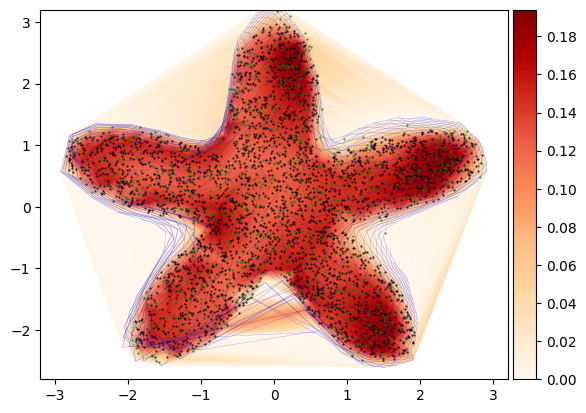

In [383]:
scale=3.2
factor=3.1

sampling_data = torch.tensor(np.random.normal(size=(1000,2)))
plot_transformed_grid_and_density(model_star, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1*scale,1*scale), y_lim=(-1*2.8,1*scale),
                                density_function=compute_gaussian_density, name='starfish_gaussian_2.png')

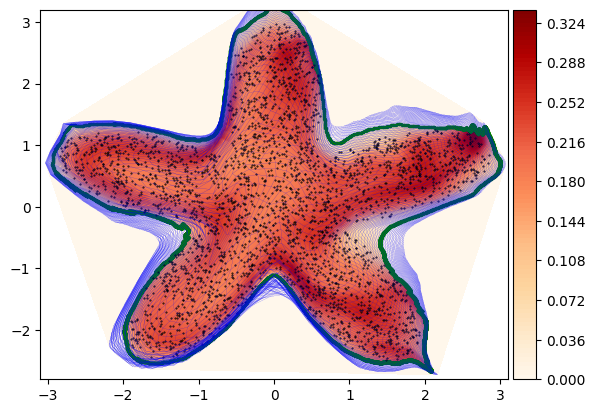

In [382]:
plot_concat_density(device, model_circle, model_star, training_set.cpu().numpy(), sigma_range = 4, grid_width=100, boundary_points=20000, x_lim=(-3.1, 3.1), y_lim=(-2.8, 3.2), name='concat_starfish.png')

In [26]:
save_model(model_star, data = 'star', checkpoint_number=1)
model_loaded = load_model(num_coupling_layers=50,layer_size=2, split_size_x1=1, nn_size=(1,10), path=f"./acl_gaussian/star/experiment{1}.pth")